In [1]:
from bs4 import BeautifulSoup
from selenium import webdriver
import pandas as pd
from time import sleep
from tqdm.notebook import tqdm
import random
import os

In [2]:
if os.getcwd()[0]=='C':
    drivepath = os.getcwd()
else:
    drivepath = '/content/drive/MyDrive/Colab Notebooks'

In [3]:
### Chrome driver options
filename = 'chromedriver.exe'
chromedriver_path = os.path.join(drivepath, filename)

options = webdriver.ChromeOptions()
options.add_argument("start-maximized")
options.add_experimental_option("excludeSwitches", ["enable-automation"])
options.add_experimental_option('useAutomationExtension', False)

user_data_dir = "C:/Users/carmi/AppData/Local/Google/Chrome/User Data"
options.add_argument('--user-data-dir=' + user_data_dir)
options.add_argument('--profile-directory=profile_selenium')

In [4]:
search_keyword = ['image','defect','detection']

### Download paper's data from Google Scholar

In [5]:
download_paper = False

In [6]:
# this function for the getting inforamtion of the web page
def get_paperinfo_selenium(page_url, sleep_time= 15):
    try:
        driver = webdriver.Chrome(executable_path=chromedriver_path, options=options)
        driver.get(page_url)
        sleep(sleep_time)
        html = driver.page_source

        #parse using beautiful soup
        paper_doc = BeautifulSoup(html,'lxml')
    except Exception as e:
        print(e)
    finally:
        driver.close()
        driver.quit()

    return paper_doc

# this function for the extracting information of the tags
def get_tags(doc):
    link_tag = doc.find_all('h3',{"class" : "gs_rt"}) 
    author_tag = doc.find_all("div", {"class": "gs_a"}) #find_all

    return link_tag, author_tag

def get_papername_link_info(link_tag):
  
    paper_names = []
    links = []

    for tag in link_tag:
        if tag.a == None:
            paper_names.append(None)
            links.append(None)
        else:
            paper_names.append(tag.a.text)
            links.append(tag.a['href'])

    return paper_names, links

# function for the getting autho, year and publication information
def get_author_year_publi_info(authors_tag):
  
    years = []
    publications = []
    authors = []

    for tag in authors_tag:
        if tag:
            authors_year_pub = (tag.get_text()).replace(u'\xa0', u' ').split(' - ')
            if len(authors_year_pub)==3:
                author = authors_year_pub[0]
                year = int(authors_year_pub[1][-4:])
                publication = authors_year_pub[2]
            else:
                author = year = publication = None
        else:
            author = year = publication = None
        
        authors.append(author)
        years.append(year)
        publications.append(publication)

    return years, publications, authors

# adding information in repository
def add_in_paper_repo(papername, year, author, publi, link):
    paper_repos_dict['Paper Title'].extend(papername)
    paper_repos_dict['Year'].extend(year)
    paper_repos_dict['Author'].extend(author)
    paper_repos_dict['Publication'].extend(publi)
    paper_repos_dict['Url of paper'].extend(link)

    return pd.DataFrame(paper_repos_dict)

In [7]:
if download_paper:
    # creating repository
    paper_repos_dict = {
                        'Paper Title' : [],
                        'Year' : [],
                        'Author' : [],
                        'Publication' : [],
                        'Url of paper' : [] 
                        }

    id_paper = 0

In [8]:
if not download_paper:
    ### Import list of papers finded in a CSV file
    filename = 'papers.csv'
    filepath = os.path.join(drivepath, filename)

    try:
        df_papers = pd.read_csv(filepath, sep=';', header=0)
        display(df_papers)
    except:
        pass

,Paper Title,Year,Author,Publication,Url of paper
0,Fabric defect detection and classification usi...,1995.0,"YF Zhang, RR Bresee",journals.sagepub.com,https://journals.sagepub.com/doi/abs/10.1177/0...
1,Approaches for improvement of the X-ray image ...,2019.0,"W Du, H Shen, J Fu, G Zhang, Q He",Elsevier,https://www.sciencedirect.com/science/article/...
2,The application of one-class classifier based ...,2017.0,"M Zhang, J Wu, H Lin, P Yuan, Y Song",Elsevier,https://www.sciencedirect.com/science/article/...
3,Review of pavement defect detection methods,2020.0,"W Cao, Q Liu, Z He",ieeexplore.ieee.org,https://ieeexplore.ieee.org/abstract/document/...
4,Image segmentation algorithms applied to wood ...,2003.0,"JW Funck, Y Zhong, DA Butler, CC Brunner…",Elsevier,https://www.sciencedirect.com/science/article/...
...,...,...,...,...,...
979,A novel defect detection and identification me...,2014.0,"L Xie, R Huang, N Gu, Z Cao",Springer,https://link.springer.com/article/10.1007/s005...
980,Surface Defect Detection Model for Aero-Engine...,2022.0,"X Li, C Wang, H Ju, Z Li",mdpi.com,https://www.mdpi.com/2076-3417/12/14/7235
981,Defect segmentation of hot-rolled steel strip ...,2019.0,"S Youkachen, M Ruchanurucks…",ieeexplore.ieee.org,https://ieeexplore.ieee.org/abstract/document/...
982,Machine parts recognition and defect detection...,2016.0,"P Arjun, TT Mirnalinee",pdfs.semanticscholar.org,https://pdfs.semanticscholar.org/cc20/8979e8f5...


In [9]:
if download_paper:
    ### Link to the GS search
    # get url for the each page
    url_start = "https://scholar.google.com/scholar?start={}&q="
    query_url = '+'.join(search_keyword)
    url_end = "&hl=en&as_sdt=0,5"

    url0 = url_start + query_url + url_end

    for i in tqdm(range(id_paper,990,10)):

        id_paper = i
        url = url0.format(i)

        doc = get_paperinfo_selenium(url, sleep_time=15)
        if doc == None:
            break

        # function for the collecting tags
        link_tag, author_tag = get_tags(doc)

        # paper title and link from each page
        papername, link = get_papername_link_info(link_tag)

        # year , author , publication of the paper
        year, publication, author = get_author_year_publi_info(author_tag)

        print("ID:", i, "-", papername[0])

        # add in paper repo dict
        df_papers = add_in_paper_repo(papername,
                                year,
                                author,
                                publication,
                                link)

In [10]:
### Cleaning of thre scraping
df_papers = df_papers.drop_duplicates()
df_papers = df_papers.dropna()
df_papers

,Paper Title,Year,Author,Publication,Url of paper
0,Fabric defect detection and classification usi...,1995.0,"YF Zhang, RR Bresee",journals.sagepub.com,https://journals.sagepub.com/doi/abs/10.1177/0...
1,Approaches for improvement of the X-ray image ...,2019.0,"W Du, H Shen, J Fu, G Zhang, Q He",Elsevier,https://www.sciencedirect.com/science/article/...
2,The application of one-class classifier based ...,2017.0,"M Zhang, J Wu, H Lin, P Yuan, Y Song",Elsevier,https://www.sciencedirect.com/science/article/...
3,Review of pavement defect detection methods,2020.0,"W Cao, Q Liu, Z He",ieeexplore.ieee.org,https://ieeexplore.ieee.org/abstract/document/...
4,Image segmentation algorithms applied to wood ...,2003.0,"JW Funck, Y Zhong, DA Butler, CC Brunner…",Elsevier,https://www.sciencedirect.com/science/article/...
...,...,...,...,...,...
979,A novel defect detection and identification me...,2014.0,"L Xie, R Huang, N Gu, Z Cao",Springer,https://link.springer.com/article/10.1007/s005...
980,Surface Defect Detection Model for Aero-Engine...,2022.0,"X Li, C Wang, H Ju, Z Li",mdpi.com,https://www.mdpi.com/2076-3417/12/14/7235
981,Defect segmentation of hot-rolled steel strip ...,2019.0,"S Youkachen, M Ruchanurucks…",ieeexplore.ieee.org,https://ieeexplore.ieee.org/abstract/document/...
982,Machine parts recognition and defect detection...,2016.0,"P Arjun, TT Mirnalinee",pdfs.semanticscholar.org,https://pdfs.semanticscholar.org/cc20/8979e8f5...


In [11]:
### Export list of papers finded in a CSV file
filename = 'papers.csv'
filepath = os.path.join(drivepath, filename)

df_papers.to_csv(filepath, mode='w', sep=';', index=False, header=True)

df_papers

,Paper Title,Year,Author,Publication,Url of paper
0,Fabric defect detection and classification usi...,1995.0,"YF Zhang, RR Bresee",journals.sagepub.com,https://journals.sagepub.com/doi/abs/10.1177/0...
1,Approaches for improvement of the X-ray image ...,2019.0,"W Du, H Shen, J Fu, G Zhang, Q He",Elsevier,https://www.sciencedirect.com/science/article/...
2,The application of one-class classifier based ...,2017.0,"M Zhang, J Wu, H Lin, P Yuan, Y Song",Elsevier,https://www.sciencedirect.com/science/article/...
3,Review of pavement defect detection methods,2020.0,"W Cao, Q Liu, Z He",ieeexplore.ieee.org,https://ieeexplore.ieee.org/abstract/document/...
4,Image segmentation algorithms applied to wood ...,2003.0,"JW Funck, Y Zhong, DA Butler, CC Brunner…",Elsevier,https://www.sciencedirect.com/science/article/...
...,...,...,...,...,...
979,A novel defect detection and identification me...,2014.0,"L Xie, R Huang, N Gu, Z Cao",Springer,https://link.springer.com/article/10.1007/s005...
980,Surface Defect Detection Model for Aero-Engine...,2022.0,"X Li, C Wang, H Ju, Z Li",mdpi.com,https://www.mdpi.com/2076-3417/12/14/7235
981,Defect segmentation of hot-rolled steel strip ...,2019.0,"S Youkachen, M Ruchanurucks…",ieeexplore.ieee.org,https://ieeexplore.ieee.org/abstract/document/...
982,Machine parts recognition and defect detection...,2016.0,"P Arjun, TT Mirnalinee",pdfs.semanticscholar.org,https://pdfs.semanticscholar.org/cc20/8979e8f5...


### Download paper's abstracts from the paper's links

In [12]:
def extract_abstract_from_source(doc):
    if doc.find('div', {"id": "abstracts"} ):
        abstract = doc.find('div', {"id": "abstracts"} ).get_text()

    elif doc.find('div', {"id": "abstract"} ):
        abstract = doc.find('div', {"id": "abstract"} ).get_text()

    elif doc.find('div', {"class": "article-abstract"} ):
        abstract = doc.find('div', {"class": "article-abstract"} ).get_text()

    elif doc.find('blockquote', {"class": "abstract mathjax"} ):
        abstract = doc.find('blockquote', {"class": "abstract mathjax"} ).get_text()

    elif doc.find('section', {"class": "abstract"} ):
        abstract = doc.find('section', {"class": "abstract"} ).get_text()

    elif doc.find('section', {"class": "document-abstract document-tab"} ):
        abstract = doc.find('section', {"class": "document-abstract document-tab"} ).get_text()

    elif doc.find('div', {"class": "contentCol"} ): #ASABE
        abstract = doc.find('div', {"class": "contentCol"} ).get_text()

    elif doc.find('div', {"class": "article-text wd-jnl-art-abstract cf"} ):
        abstract = doc.find('div', {"class": "article-text wd-jnl-art-abstract cf"} ).get_text()

    elif doc.find('div', {"class": "c-article-section__content"} ): #Springer
        abstract = doc.find('div', {"class": "c-article-section__content"} ).get_text()

    elif doc.find('div', {"class": "abstractSection abstractInFull"} ): #Taylor&Francis
        abstract = doc.find('div', {"class": "abstractSection abstractInFull"} ).get_text()

    elif doc.find('table', {"id": "UsageTable1"} ): #SPIE.Library
        abstract = doc.find('table', {"id": "UsageTable1"} ).get_text()

    elif doc.find('textarea', {"class": "TextArea2"} ): #Airti Library
        abstract = doc.find('textarea', {"class": "TextArea2"} ).get_text()

    elif doc.find('div', {"class": "xml-content"} ): #Hindawi
        abstract = doc.find('div', {"class": "xml-content"} ).get_text()

    elif doc.find('div', {"class": "abstract-group"} ): #Wiley Online Library
        abstract = doc.find('div', {"class": "abstract-group"} ).get_text()

    elif doc.find('section', {"class": "intent_abstract pt-2 mb-5 Abstract"}): #Emerdald
        abstract = doc.find('section', {"class": "intent_abstract pt-2 mb-5 Abstract"}).get_text()

    elif doc.find('p', {"class": "g-color-gray-dark-v2 text-justify"}): #Korea Science
        abstract = doc.find('p', {"class": "g-color-gray-dark-v2 text-justify"}).get_text()
        
    else:
        abstract = None

    return abstract

def get_abstract_selenium(paper_url, sleep_time=15):
    
    driver = webdriver.Chrome(executable_path=chromedriver_path, options=options)
    try:
        driver.get(paper_url)
        sleep(10)
        html = driver.page_source    
        #parse using beautiful soup
        doc = BeautifulSoup(html,'lxml')
        abstract = extract_abstract_from_source(doc)
        
    except Exception as e:
        print(e)
        abstract = None

    finally:
    ### close chrome driver
        driver.close()
        driver.quit()
    
    return abstract

In [13]:
### Create Abstract column
df_papers['Abstract'] = None

df_papers

,Paper Title,Year,Author,Publication,Url of paper,Abstract
0,Fabric defect detection and classification usi...,1995.0,"YF Zhang, RR Bresee",journals.sagepub.com,https://journals.sagepub.com/doi/abs/10.1177/0...,None
1,Approaches for improvement of the X-ray image ...,2019.0,"W Du, H Shen, J Fu, G Zhang, Q He",Elsevier,https://www.sciencedirect.com/science/article/...,None
2,The application of one-class classifier based ...,2017.0,"M Zhang, J Wu, H Lin, P Yuan, Y Song",Elsevier,https://www.sciencedirect.com/science/article/...,None
3,Review of pavement defect detection methods,2020.0,"W Cao, Q Liu, Z He",ieeexplore.ieee.org,https://ieeexplore.ieee.org/abstract/document/...,None
4,Image segmentation algorithms applied to wood ...,2003.0,"JW Funck, Y Zhong, DA Butler, CC Brunner…",Elsevier,https://www.sciencedirect.com/science/article/...,None
...,...,...,...,...,...,...
979,A novel defect detection and identification me...,2014.0,"L Xie, R Huang, N Gu, Z Cao",Springer,https://link.springer.com/article/10.1007/s005...,None
980,Surface Defect Detection Model for Aero-Engine...,2022.0,"X Li, C Wang, H Ju, Z Li",mdpi.com,https://www.mdpi.com/2076-3417/12/14/7235,None
981,Defect segmentation of hot-rolled steel strip ...,2019.0,"S Youkachen, M Ruchanurucks…",ieeexplore.ieee.org,https://ieeexplore.ieee.org/abstract/document/...,None
982,Machine parts recognition and defect detection...,2016.0,"P Arjun, TT Mirnalinee",pdfs.semanticscholar.org,https://pdfs.semanticscholar.org/cc20/8979e8f5...,None


In [14]:
### Import papers dataframe from HDF5 file
filename = 'papers_abstract_raw.h5'
filepath = os.path.join(drivepath, filename)

try:
    df_papers = pd.read_hdf(filepath, 'df_papers')
    display(df_papers)
except:
    pass

,Paper Title,Year,Author,Publication,Url of paper,Abstract
0,Fabric defect detection and classification usi...,1995.0,"YF Zhang, RR Bresee",journals.sagepub.com,https://journals.sagepub.com/doi/abs/10.1177/0...,Conventional image analysis hardware was used ...
1,Approaches for improvement of the X-ray image ...,2019.0,"W Du, H Shen, J Fu, G Zhang, Q He",Elsevier,https://www.sciencedirect.com/science/article/...,There are two contributions to this work:(i)Fe...
2,The application of one-class classifier based ...,2017.0,"M Zhang, J Wu, H Lin, P Yuan, Y Song",Elsevier,https://www.sciencedirect.com/science/article/...,"In the field of defect detection, image proces..."
3,Review of pavement defect detection methods,2020.0,"W Cao, Q Liu, Z He",ieeexplore.ieee.org,https://ieeexplore.ieee.org/abstract/document/...,Road pavement cracks detection has been a hot ...
4,Image segmentation algorithms applied to wood ...,2003.0,"JW Funck, Y Zhong, DA Butler, CC Brunner…",Elsevier,https://www.sciencedirect.com/science/article/...,Image segmentation is a key stage in the detec...
...,...,...,...,...,...,...
985,A novel defect detection and identification me...,2014.0,"L Xie, R Huang, N Gu, Z Cao",Springer,https://link.springer.com/article/10.1007/s005...,Optical inspection techniques have been widely...
986,Surface Defect Detection Model for Aero-Engine...,2022.0,"X Li, C Wang, H Ju, Z Li",mdpi.com,https://www.mdpi.com/2076-3417/12/14/7235,Aiming at the problems of low efficiency and p...
987,Defect segmentation of hot-rolled steel strip ...,2019.0,"S Youkachen, M Ruchanurucks…",ieeexplore.ieee.org,https://ieeexplore.ieee.org/abstract/document/...,Defects on steel strip surface can long-term c...
988,Machine parts recognition and defect detection...,2016.0,"P Arjun, TT Mirnalinee",pdfs.semanticscholar.org,https://pdfs.semanticscholar.org/cc20/8979e8f5...,None


In [16]:
### Pubblication houses to scrape
df_publication_miss = df_papers.loc[(df_papers['Abstract'].isna()) & (df_papers['Url of paper'].str[-3:]!='pdf')]

df_aggr = df_publication_miss.groupby('Publication')['Publication'].count().sort_values(ascending=False)
df_aggr = df_aggr.loc[df_aggr.values>10]
display(df_aggr)

pub_list = df_aggr.index.tolist()

df_to_scrape = df_papers.loc[ (df_papers['Abstract'].isna()) & (df_papers['Publication'].isin(pub_list)) ]

display(df_to_scrape.head(3))

print("Abstracts to scrape:",df_to_scrape.shape[0])

Publication
spiedigitallibrary.org    18
iopscience.iop.org        17
Wiley Online Library      16
Name: Publication, dtype: int64

,Paper Title,Year,Author,Publication,Url of paper,Abstract
55,Integration of colour and textural information...,2007.0,"JM Prats‐Montalbán, A Ferrer",Wiley Online Library,https://analyticalsciencejournals.onlinelibrar...,None
63,Welding defect detection based on local image ...,2019.0,"Z Lin, Z Yingjie, D Bochao, C Bo…",Wiley Online Library,https://ietresearch.onlinelibrary.wiley.com/do...,None
65,Fabric defect detection based on golden image ...,2017.0,"JF Jing, S Chen, PF Li",Wiley Online Library,https://onlinelibrary.wiley.com/doi/abs/10.111...,None


Abstracts to scrape: 51


In [ ]:
for i, r in tqdm(df_to_scrape.iterrows(), total = df_to_scrape.shape[0]):
    
    link_paper = r['Url of paper']
    abstract = get_abstract_selenium(link_paper, sleep_time=30)
    
    (print("ID:", i, "-", abstract[:50], "...") if abstract else print("ID:", i, "-", link_paper))
    
    ### Updating the abstract data to the dataframe
    df_papers.loc[i, 'Abstract'] = abstract

df_papers

In [17]:
print("Abstracts downloaded:",round(df_papers.loc[df_papers["Abstract"].notnull()].shape[0]/df_papers.shape[0]*100,2))

Abstracts downloaded: 80.51


In [18]:
### Pubblication houses not scraped
df_publication_miss = df_papers.loc[(df_papers['Abstract'].isna()) & (df_papers['Url of paper'].str[-3:]!='pdf')]

dg_aggr = df_publication_miss.groupby('Publication')['Publication'].count().sort_values(ascending=False)

dg_aggr.loc[dg_aggr>10]

Publication
spiedigitallibrary.org    18
iopscience.iop.org        17
Wiley Online Library      16
Name: Publication, dtype: int64

In [19]:
### Export papers dataframe in HDF5 file
filename = 'papers_abstract_raw.h5'
filepath = os.path.join(drivepath, filename)

df_papers.to_hdf(filepath, key='df_papers', mode='w')

pd.read_hdf(filepath, 'df_papers')

C:\Users\carmi\AppData\Local\Temp\ipykernel_14480\1187607237.py:5: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block0_values] [items->Index(['Paper Title', 'Author', 'Publication', 'Url of paper', 'Abstract'], dtype='object')]

  df_papers.to_hdf(filepath, key='df_papers', mode='w')


,Paper Title,Year,Author,Publication,Url of paper,Abstract
0,Fabric defect detection and classification usi...,1995.0,"YF Zhang, RR Bresee",journals.sagepub.com,https://journals.sagepub.com/doi/abs/10.1177/0...,Conventional image analysis hardware was used ...
1,Approaches for improvement of the X-ray image ...,2019.0,"W Du, H Shen, J Fu, G Zhang, Q He",Elsevier,https://www.sciencedirect.com/science/article/...,There are two contributions to this work:(i)Fe...
2,The application of one-class classifier based ...,2017.0,"M Zhang, J Wu, H Lin, P Yuan, Y Song",Elsevier,https://www.sciencedirect.com/science/article/...,"In the field of defect detection, image proces..."
3,Review of pavement defect detection methods,2020.0,"W Cao, Q Liu, Z He",ieeexplore.ieee.org,https://ieeexplore.ieee.org/abstract/document/...,Road pavement cracks detection has been a hot ...
4,Image segmentation algorithms applied to wood ...,2003.0,"JW Funck, Y Zhong, DA Butler, CC Brunner…",Elsevier,https://www.sciencedirect.com/science/article/...,Image segmentation is a key stage in the detec...
...,...,...,...,...,...,...
985,A novel defect detection and identification me...,2014.0,"L Xie, R Huang, N Gu, Z Cao",Springer,https://link.springer.com/article/10.1007/s005...,Optical inspection techniques have been widely...
986,Surface Defect Detection Model for Aero-Engine...,2022.0,"X Li, C Wang, H Ju, Z Li",mdpi.com,https://www.mdpi.com/2076-3417/12/14/7235,Aiming at the problems of low efficiency and p...
987,Defect segmentation of hot-rolled steel strip ...,2019.0,"S Youkachen, M Ruchanurucks…",ieeexplore.ieee.org,https://ieeexplore.ieee.org/abstract/document/...,Defects on steel strip surface can long-term c...
988,Machine parts recognition and defect detection...,2016.0,"P Arjun, TT Mirnalinee",pdfs.semanticscholar.org,https://pdfs.semanticscholar.org/cc20/8979e8f5...,None


### Data cleaning

<AxesSubplot:>

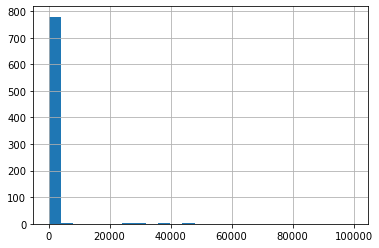

In [20]:
### Lengths of the Abstract downloaded
(df_papers.loc[df_papers['Abstract'].notnull()]['Abstract'].apply(lambda x: len(x) if x else 0)).hist(bins=25)

In [21]:
def skip_text(text, text_to_find, pos = 'start'):
    if text==None:
        return None
    elif text.find(text_to_find) == -1:
        return text
    elif pos == 'start':
        return text[text.find(text_to_find)+len(text_to_find):]
    elif pos == 'end':
        return text[:text.find(text_to_find)]

In [22]:
### Fix ASABE
start_text = '\n\n\t\n\n\n\nABSTRACT '
end_text = '\n\n\n\n\n\t\t\t\t\t\t\t\t\t(Download PDF)\t\t\t\t\t\t\t\t\t'

df_papers["Abstract"] = df_papers["Abstract"].apply(lambda x: skip_text(x, start_text, pos='start') )
df_papers["Abstract"] = df_papers["Abstract"].apply(lambda x: skip_text(x, end_text, pos='end') )

start_text = 'HIGHLIGHTSA '
end_text = '\n\n\n\n\t\t\t\t\t\t\t\t\t(Download PDF)'

df_papers["Abstract"] = df_papers["Abstract"].apply(lambda x: skip_text(x, start_text, pos='start') )
df_papers["Abstract"] = df_papers["Abstract"].apply(lambda x: skip_text(x, end_text, pos='end') )

start_text = '\n\n\t\n\n\n\n'
df_papers["Abstract"] = df_papers["Abstract"].apply(lambda x: skip_text(x, start_text, pos='start') )

### Fix hindawi
end_text = '1. Introduction'

df_papers["Abstract"] = df_papers["Abstract"].apply(lambda x: skip_text(x, end_text, pos='end') )

### Fix OpenArticle problem of dowloaded texts
start_text = 'This Paper\n\n\n\n\n\n\n\n\nAbstract\n\n\n\n'
end_text = '\nView Full-Text\n\nKeywords:'

df_papers["Abstract"] = df_papers["Abstract"].apply(lambda x: skip_text(x, start_text, pos='start') )
df_papers["Abstract"] = df_papers["Abstract"].apply(lambda x: skip_text(x, end_text, pos='end') )

### Fix IEEE Access problem of dowloaded texts
start_text = '...View more Abstract:'
end_text = 'Published in: IEEE Access'

df_papers["Abstract"] = df_papers["Abstract"].apply(lambda x: skip_text(x, start_text, pos='start') )
df_papers["Abstract"] = df_papers["Abstract"].apply(lambda x: skip_text(x, end_text, pos='end') )

### Fix IEEE Xplore problem of dowloaded texts
start_text = '...View moreMetadata Abstract:'
end_text = 'Published in: '

df_papers["Abstract"] = df_papers["Abstract"].apply(lambda x: skip_text(x, start_text, pos='start') )
df_papers["Abstract"] = df_papers["Abstract"].apply(lambda x: skip_text(x, end_text, pos='end') )

start_text = '...View moreTopic:'
end_text = 'Topic: '

df_papers["Abstract"] = df_papers["Abstract"].apply(lambda x: skip_text(x, start_text, pos='start') )
df_papers["Abstract"] = df_papers["Abstract"].apply(lambda x: skip_text(x, end_text, pos='end') )

###### 
end_text = 'KeywordsPositive '
df_papers["Abstract"] = df_papers["Abstract"].apply(lambda x: skip_text(x, end_text, pos='end') )

### Fix Elsevier
end_text = 'Graphical AbstractDownload'
df_papers["Abstract"] = df_papers["Abstract"].apply(lambda x: skip_text(x, end_text, pos='end') )

end_text = 'Graphical abstractDownload :'
df_papers["Abstract"] = df_papers["Abstract"].apply(lambda x: skip_text(x, end_text, pos='end') )

end_text = 'Highlights►'
df_papers["Abstract"] = df_papers["Abstract"].apply(lambda x: skip_text(x, end_text, pos='end') )

### Fix MDPI
end_text = '\n View Full-Text\n\nKeywords:'
df_papers["Abstract"] = df_papers["Abstract"].apply(lambda x: skip_text(x, end_text, pos='end') )

In [23]:
def remove_intial_char(text, char=' '):
    if text==None:
        return None
    char_len = len(char)
    if text[:char_len].lower()==char.lower():
        text = text[char_len:]
        text = remove_intial_char(text, char)
    
    return text

def remove_final_char(text, char=' '):
    if text==None:
        return None
    char_len = len(char)
    if text[-char_len:].lower()==char.lower():
        text = text[:-char_len]
        text = remove_final_char(text, char)
    
    return text

In [24]:
### Remove "\n" from the doc

chars_list = ['\n',' ','abstract','highlights',':','•','\t','Purpose']

for n in range(len(chars_list)):
    for c in chars_list:
        df_papers["Abstract"] = df_papers["Abstract"].apply(lambda x: remove_intial_char(x,char=c) )
        df_papers["Abstract"] = df_papers["Abstract"].apply(lambda x: remove_final_char(x,char=c) )


<AxesSubplot:>

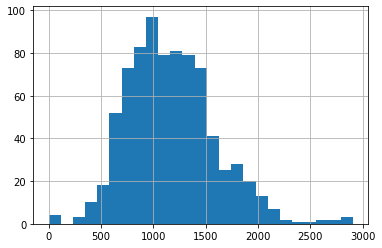

In [25]:
### Lengths of the Abstract downloaded
(df_papers.loc[df_papers['Abstract'].notnull()]['Abstract'].apply(lambda x: len(x) if x else 0)).hist(bins=25)

In [40]:
# df_papers['Abstract'][df_papers['Abstract'].apply(lambda x: len(x)>1500 if x else False)]

In [41]:
# df_papers['Abstract'].loc[13]

### Export final Data

In [26]:
### Export papers dataframe in HDF5 file
filename = 'papers_abstract.h5'
filepath = os.path.join(drivepath, filename)

df_papers.to_hdf(filepath, key='df_papers', mode='w')

pd.read_hdf(filepath, 'df_papers')

C:\Users\carmi\AppData\Local\Temp\ipykernel_14480\168660746.py:5: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block1_values] [items->Index(['Paper Title', 'Author', 'Publication', 'Url of paper', 'Abstract'], dtype='object')]

  df_papers.to_hdf(filepath, key='df_papers', mode='w')


,Paper Title,Year,Author,Publication,Url of paper,Abstract
0,Fabric defect detection and classification usi...,1995.0,"YF Zhang, RR Bresee",journals.sagepub.com,https://journals.sagepub.com/doi/abs/10.1177/0...,Conventional image analysis hardware was used ...
1,Approaches for improvement of the X-ray image ...,2019.0,"W Du, H Shen, J Fu, G Zhang, Q He",Elsevier,https://www.sciencedirect.com/science/article/...,There are two contributions to this work:(i)Fe...
2,The application of one-class classifier based ...,2017.0,"M Zhang, J Wu, H Lin, P Yuan, Y Song",Elsevier,https://www.sciencedirect.com/science/article/...,"In the field of defect detection, image proces..."
3,Review of pavement defect detection methods,2020.0,"W Cao, Q Liu, Z He",ieeexplore.ieee.org,https://ieeexplore.ieee.org/abstract/document/...,Road pavement cracks detection has been a hot ...
4,Image segmentation algorithms applied to wood ...,2003.0,"JW Funck, Y Zhong, DA Butler, CC Brunner…",Elsevier,https://www.sciencedirect.com/science/article/...,Image segmentation is a key stage in the detec...
...,...,...,...,...,...,...
985,A novel defect detection and identification me...,2014.0,"L Xie, R Huang, N Gu, Z Cao",Springer,https://link.springer.com/article/10.1007/s005...,Optical inspection techniques have been widely...
986,Surface Defect Detection Model for Aero-Engine...,2022.0,"X Li, C Wang, H Ju, Z Li",mdpi.com,https://www.mdpi.com/2076-3417/12/14/7235,Aiming at the problems of low efficiency and p...
987,Defect segmentation of hot-rolled steel strip ...,2019.0,"S Youkachen, M Ruchanurucks…",ieeexplore.ieee.org,https://ieeexplore.ieee.org/abstract/document/...,Defects on steel strip surface can long-term c...
988,Machine parts recognition and defect detection...,2016.0,"P Arjun, TT Mirnalinee",pdfs.semanticscholar.org,https://pdfs.semanticscholar.org/cc20/8979e8f5...,None
